# 기본 코드(ResNet50, 출력층) / epoch=20, patience?=5, dropout=0.4가 그나마 제일 잘나옴

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Epoch 1, Train Loss: 1.5207, Train Accuracy: 74.50%
Validation Loss: 0.3797, Validation Accuracy: 90.55%
insert log for epoch 1
Epoch 2, Train Loss: 0.2117, Train Accuracy: 92.99%
Validation Loss: 0.3178, Validation Accuracy: 91.82%
insert log for epoch 2
Epoch 3, Train Loss: 0.1521, Train Accuracy: 94.90%
Validation Loss: 0.2238, Validation Accuracy: 92.55%
insert log for epoch 3
Epoch 4, Train Loss: 0.0937, Train Accuracy: 97.13%
Validation Loss: 0.3245, Validation Accuracy: 90.18%
insert log for epoch 4
Epoch 5, Train Loss: 0.0870, Train Accuracy: 97.22%
Validation Loss: 0.3637, Validation Accuracy: 91.64%
insert log for epoch 5
Epoch 6, Train Loss: 0.0770, Train Accuracy: 97.59%
Validation Loss: 0.3221, Validation Accuracy: 91.45%
insert log for epoch 6
Epoch 7, Train Loss: 0.0501, Train Accuracy: 98.32%
Validation Loss: 0.3179, Validation Accuracy: 91.45%
insert log for epoch 7
Epoch 8, Train Loss: 0.0619, Train Accuracy: 98.32%
Validation Loss: 0.3062, Validation Accuracy: 91.45%

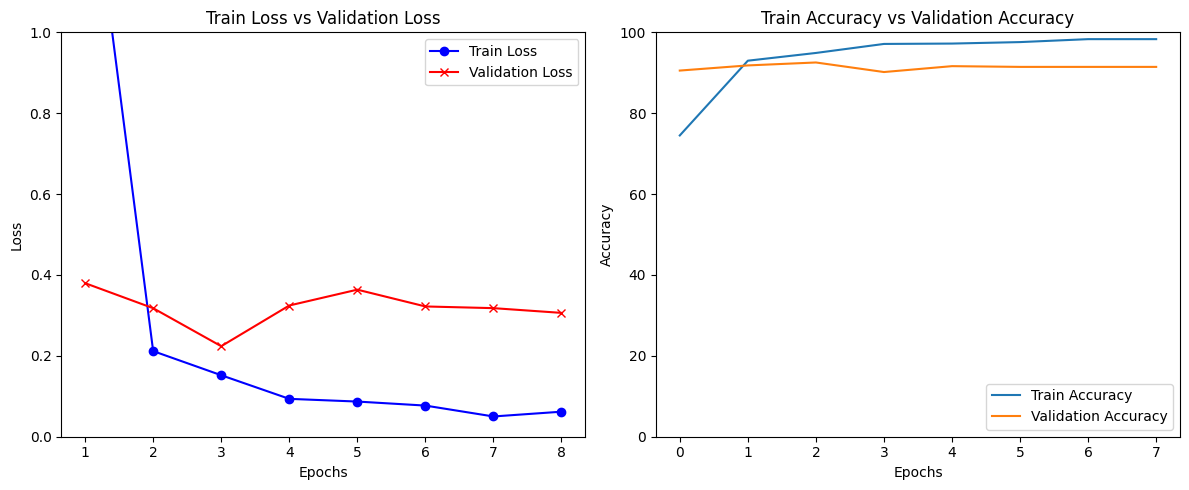

Train Losses:  [1.5206510529353998, 0.21174339653141255, 0.15208134754304437, 0.09365567017643564, 0.08695910316284584, 0.07700669425337212, 0.05009951974953646, 0.06189873853050496]
Validation Losses:  [0.3797465397251977, 0.31783247118194896, 0.22383197645346323, 0.3244911382595698, 0.3636665766437848, 0.322133917775419, 0.3179400563240051, 0.30624257276455563]
Test Accuracy: 0.92%


In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch.optim.lr_scheduler as lr_scheduler
import glob


# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# 데이터셋 클래스 정의
class FlowerDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        img = Image.open(img_path)
        if self.transform:
            img = self.transform(img)
        return img, label


# 모델 정의 - 출력층 자체에 dropout
class ResNet50Model(nn.Module):
    def __init__(self, num_classes=5, dropout_prob=0.3):
        super(ResNet50Model, self).__init__()
        self.model = models.resnet50(pretrained=True)

        self.model.fc = nn.Sequential(
        nn.Dropout(p=dropout_prob),  # Dropout 추가
        self.model.fc  # 기존 출력층 유지
        )

        # 기본적으로 모든 파라미터를 학습 가능하게 설정
        for param in self.model.parameters():
            param.requires_grad = True

    def forward(self, x):
        return self.model(x)

# 모델 학습, 평가, db 연결 클래스
class TrainModel:
    def __init__(self, model, train_loader, val_loader, test_loader, lr=0.0001, patience=5, scheduler_step_size=10, scheduler_gamma=0.5):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=0.0005) #L2 정규화 적용
        self.patience = patience
        self.best_val_loss = float('inf')
        self.early_stop_counter = 0
        self.scheduler = lr_scheduler.StepLR(self.optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma)

        self.train_losses = []
        self.train_accuracies = []
        self.val_losses = []
        self.val_accuracies = []

        self.test_accuracy = None

        # SQLite 데이터베이스 연결 및 테이블 생성
        self.conn = sqlite3.connect('training_logs.db')
        self.cursor = self.conn.cursor()
        self.cursor.execute('''CREATE TABLE IF NOT EXISTS logs (
                                timestamp TEXT,
                                epoch INTEGER,
                                train_loss REAL,
                                train_accuracy REAL,
                                val_loss REAL,
                                val_accuracy REAL,
                                test_accuracy REAL
                            )''')

    def log_to_db(self, epoch, train_loss, train_accuracy, val_loss, val_accuracy, test_accuracy):
        timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        print(f"insert log for epoch {epoch}")
        self.cursor.execute('''INSERT INTO logs (timestamp, epoch, train_loss, train_accuracy, val_loss, val_accuracy, test_accuracy)
                               VALUES (?, ?, ?, ?, ?, ?, ?)''',
                            (timestamp, epoch, train_loss, train_accuracy, val_loss, val_accuracy, test_accuracy))
        self.conn.commit()

    def train(self, epochs):
        for epoch in range(epochs):
            self.model.train()
            running_loss = 0.0
            correct_train = 0
            total_train = 0
            for images, labels in self.train_loader:
                images, labels = images.to(device), labels.to(device)
                self.optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()

            train_loss = running_loss / len(self.train_loader)
            train_accuracy = 100 * correct_train / total_train
            self.train_losses.append(train_loss)
            self.train_accuracies.append(train_accuracy)
            print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

            val_loss = self.evaluate(self.val_loader)
            val_accuracy = 100 * self.evaluate_accuracy(self.val_loader)
            self.val_losses.append(val_loss)
            self.val_accuracies.append(val_accuracy)

            print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

            # Early Stopping 조건 체크
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.early_stop_counter = 0
            else:
                self.early_stop_counter += 1
                if self.early_stop_counter >= self.patience:
                    print("Early stopping triggered")
                    break

            self.scheduler.step()

             # 로그를 SQLite에 저장
            self.log_to_db(epoch + 1, train_loss, train_accuracy, val_loss, val_accuracy, self.test_accuracy)

        self.test_accuracy = self.evaluate_accuracy(self.test_loader)
        print(f"Test Accuracy: {self.test_accuracy * 100:.2f}%")

        self.plot_graph()

        return {
            'train_losses': self.train_losses,
            'train_accuracies': self.train_accuracies,
            'val_losses': self.val_losses,
            'val_accuracies': self.val_accuracies,
            'test_accuracy': self.test_accuracy
        }

    def evaluate(self, loader):
        self.model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in loader:
                images, labels = images.to(device), labels.to(device)
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(loader)
        return avg_val_loss

    def evaluate_accuracy(self, loader):
        self.model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in loader:
                images, labels = images.to(device), labels.to(device)
                outputs = self.model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = correct / total
        return accuracy

    def plot_graph(self):
        if len(self.train_losses) > 0 and len(self.val_accuracies) > 0:  # 리스트가 비어있는지 체크
            epochs = range(1, len(self.train_losses) + 1)

        plt.figure(figsize=(12, 5))

        ax1 = plt.subplot(1, 2, 1)
        ax1.plot(epochs, self.train_losses, 'b-o', label='Train Loss')
        ax1.plot(epochs, self.val_losses, 'r-x', label='Validation Loss')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax1.legend(loc='upper right')
        ax1.set_title('Train Loss vs Validation Loss')
        ax1.set_ylim(0, 1)

        ax2 = plt.subplot(1, 2, 2)
        ax2.plot(self.train_accuracies, label='Train Accuracy')
        ax2.plot(self.val_accuracies, label='Validation Accuracy')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Accuracy')
        ax2.legend(loc='lower right')
        ax2.set_title('Train Accuracy vs Validation Accuracy')
        ax2.set_ylim(0, 100)

        plt.tight_layout()
        plt.show()


# Flower Dataset 폴더 경로와 class 이름 설정
train_data_path = "/content/drive/MyDrive/Colab Notebooks/Kakao/개인 project/flowers-dataset/train"
test_data_path = "/content/drive/MyDrive/Colab Notebooks/Kakao/개인 project/flowers-dataset/labeled_test"

# 이미지 경로와 레이블 준비
train_image_paths = glob.glob(os.path.join(train_data_path, '*', '*.jpg'))
test_image_paths = glob.glob(os.path.join(test_data_path, '*', '*.jpg'))

# 클래스 이름 딕셔너리 정의
labels_dict = {'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}

# 꽃 종류별 라벨링
train_labels = [labels_dict[os.path.basename(os.path.dirname(img_path))] for img_path in train_image_paths]
test_labels = [labels_dict[os.path.basename(os.path.dirname(img_path))] for img_path in test_image_paths]

# 데이터셋 분할 (train과 val 데이터셋 분할)
train_paths, val_paths, train_labels, val_labels = train_test_split(train_image_paths, train_labels, test_size=0.2, random_state=42)

# 이미지 전처리 및 데이터 로더 설정
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Dataset 클래스 정의 및 로더 설정
train_dataset = FlowerDataset(train_paths, train_labels, transform=train_transform)
val_dataset = FlowerDataset(val_paths, val_labels, transform=val_test_transform)
test_dataset = FlowerDataset(test_image_paths, test_labels, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 모델과 학습 클래스 준비
model = ResNet50Model(num_classes=5)
trainer = TrainModel(model, train_loader, val_loader, test_loader)

# 학습 시작
results = trainer.train(epochs=20)

# 결과 확인
print("Train Losses: ", results['train_losses'])
print("Validation Losses: ", results['val_losses'])
print(f"Test Accuracy: {results['test_accuracy']:.2f}%")

연결된 SQLite 로그 출력

In [29]:
import sqlite3

# 데이터베이스 연결
conn = sqlite3.connect('training_logs.db')
cursor = conn.cursor()

# 로그 조회 쿼리 실행
cursor.execute('SELECT * FROM logs')
rows = cursor.fetchall()

# 로그 출력
for row in rows:
    print(row)

conn.close()

('2025-03-30 10:38:33', 1, 0.6912416235908218, 80.7832422586521, 0.24577192713816962, 92.0, None)
('2025-03-30 10:44:52', 1, 0.4905721297946529, 83.24225865209472, 0.2390514531483253, 92.9090909090909, None)
('2025-03-30 10:45:14', 2, 0.20833004525174265, 92.71402550091075, 0.19094137557678753, 93.63636363636364, None)
('2025-03-30 10:45:37', 3, 0.12695677552129264, 96.03825136612022, 0.28158503770828247, 90.36363636363637, None)
('2025-03-30 10:46:00', 4, 0.08610886602622012, 96.90346083788707, 0.19254585707353222, 93.81818181818183, None)
('2025-03-30 10:46:23', 5, 0.08383394416043724, 97.040072859745, 0.21640773862600327, 92.9090909090909, None)
('2025-03-30 11:33:41', 1, 1.5554666147715803, 73.99817850637523, 0.4102249700162146, 87.63636363636364, None)
('2025-03-30 11:34:03', 2, 0.22230091674820238, 93.16939890710383, 0.3998775454238057, 87.63636363636364, None)
('2025-03-30 11:34:25', 3, 0.13581043053958294, 95.21857923497268, 0.35253329885502654, 89.45454545454545, None)
('2025-

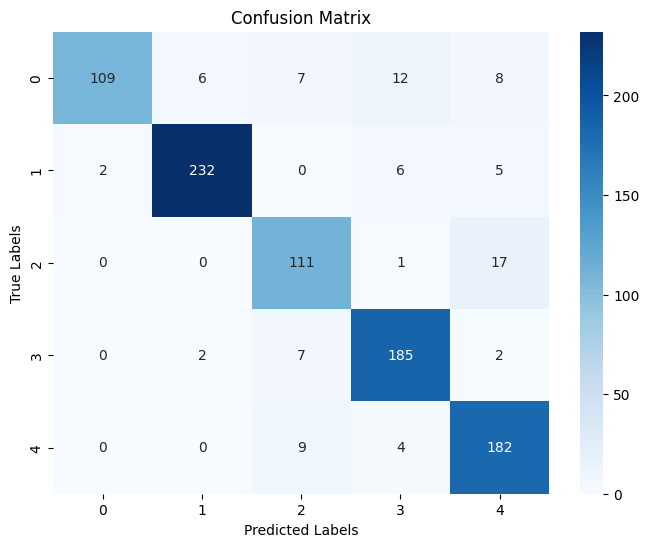

In [30]:
# 혼동행렬
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 모델 테스트 후 혼동 행렬 계산 함수
def plot_confusion_matrix(model, dataloader, device):
    model.eval()  # 모델을 평가 모드로 전환
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # 혼동 행렬 계산
    cm = confusion_matrix(all_labels, all_preds)

    # 혼동 행렬 시각화
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# 학습 후 혼동 행렬 출력
plot_confusion_matrix(model, test_loader, device)

grayscale

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Train Loss: 1.8547, Train Accuracy: 67.35%
Validation Loss: 0.6500, Validation Accuracy: 84.73%
Epoch 2, Train Loss: 0.3738, Train Accuracy: 87.89%
Validation Loss: 0.3908, Validation Accuracy: 88.55%
Epoch 3, Train Loss: 0.2065, Train Accuracy: 93.21%
Validation Loss: 0.4214, Validation Accuracy: 87.27%
Epoch 4, Train Loss: 0.2157, Train Accuracy: 93.12%
Validation Loss: 0.4760, Validation Accuracy: 86.00%
Epoch 5, Train Loss: 0.1375, Train Accuracy: 95.40%
Validation Loss: 0.4453, Validation Accuracy: 88.36%
Epoch 6, Train Loss: 0.1184, Train Accuracy: 96.31%
Validation Loss: 0.4512, Validation Accuracy: 89.27%
Early stopping triggered
Test Accuracy: 88.86%


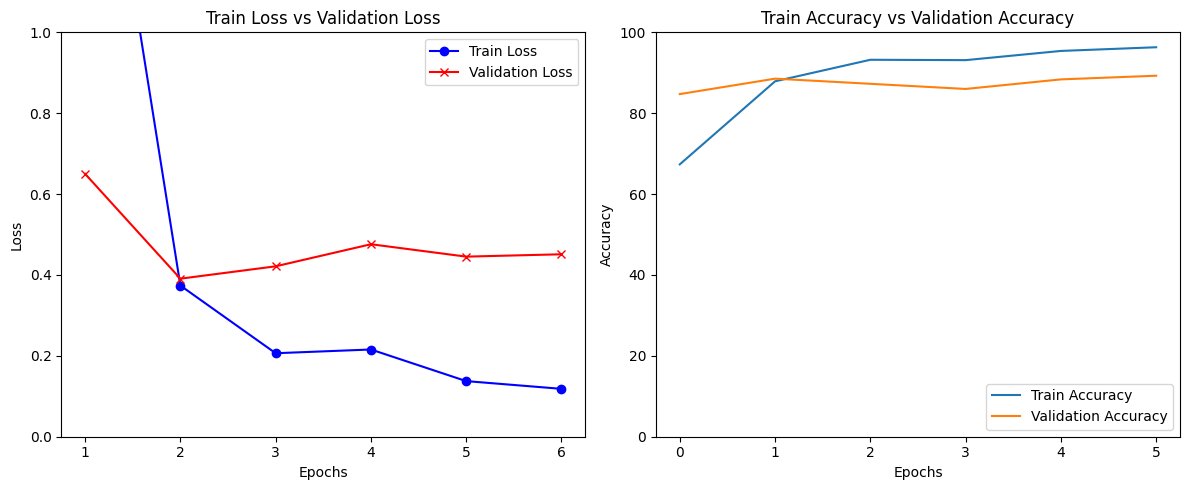

Train Losses:  [1.8546687258758408, 0.3738274073255235, 0.20647567273050116, 0.21568870239391708, 0.13751869689187277, 0.11839606311590667]
Validation Losses:  [0.6500406902697351, 0.3908199796246158, 0.4213908339540164, 0.4759962194495731, 0.4453290034499433, 0.45117049829827416]
Test Accuracy: 0.89%


In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch.optim.lr_scheduler as lr_scheduler
import glob


# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# 데이터셋 클래스 정의
class FlowerDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        img = Image.open(img_path)
        if self.transform:
            img = self.transform(img)
        return img, label


# 모델 정의 - 출력층 자체에 dropout
class ResNet50Model(nn.Module):
    def __init__(self, num_classes=5, dropout_prob=0.3):
        super(ResNet50Model, self).__init__()
        self.model = models.resnet50(pretrained=True)

        self.model.fc = nn.Sequential(
        nn.Dropout(p=dropout_prob),  # Dropout 추가
        self.model.fc  # 기존 출력층 유지
        )

        # 기본적으로 모든 파라미터를 학습 가능하게 설정
        for param in self.model.parameters():
            param.requires_grad = True

    def forward(self, x):
        return self.model(x)


# 모델 학습 및 평가 클래스
class TrainModel:
    def __init__(self, model, train_loader, val_loader, test_loader, lr=0.0001, patience=4, scheduler_step_size=10, scheduler_gamma=0.5):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=0.0005) #L2 정규화 적용
        self.patience = patience
        self.best_val_loss = float('inf')
        self.early_stop_counter = 0
        self.scheduler = lr_scheduler.StepLR(self.optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma)

        self.train_losses = []
        self.train_accuracies = []
        self.val_losses = []
        self.val_accuracies = []

        self.test_accuracy = None

    def train(self, epochs):
        for epoch in range(epochs):
            self.model.train()
            running_loss = 0.0
            correct_train = 0
            total_train = 0
            for images, labels in self.train_loader:
                images, labels = images.to(device), labels.to(device)
                self.optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()

            train_loss = running_loss / len(self.train_loader)
            train_accuracy = 100 * correct_train / total_train
            self.train_losses.append(train_loss)
            self.train_accuracies.append(train_accuracy)
            print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

            val_loss = self.evaluate(self.val_loader)
            val_accuracy = 100 * self.evaluate_accuracy(self.val_loader)
            self.val_losses.append(val_loss)
            self.val_accuracies.append(val_accuracy)

            print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

            # Early Stopping 조건 체크
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.early_stop_counter = 0
            else:
                self.early_stop_counter += 1
                if self.early_stop_counter >= self.patience:
                    print("Early stopping triggered")
                    break

            self.scheduler.step()

        self.test_accuracy = self.evaluate_accuracy(self.test_loader)
        print(f"Test Accuracy: {self.test_accuracy * 100:.2f}%")

        self.plot_graph()

        return {
            'train_losses': self.train_losses,
            'train_accuracies': self.train_accuracies,
            'val_losses': self.val_losses,
            'val_accuracies': self.val_accuracies,
            'test_accuracy': self.test_accuracy
        }

    def evaluate(self, loader):
        self.model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in loader:
                images, labels = images.to(device), labels.to(device)
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(loader)
        return avg_val_loss

    def evaluate_accuracy(self, loader):
        self.model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in loader:
                images, labels = images.to(device), labels.to(device)
                outputs = self.model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = correct / total
        return accuracy

    def plot_graph(self):
        if len(self.train_losses) > 0 and len(self.val_accuracies) > 0:  # 리스트가 비어있는지 체크
            epochs = range(1, len(self.train_losses) + 1)  # train_losses의 길이에 맞추기

        plt.figure(figsize=(12, 5))

        ax1 = plt.subplot(1, 2, 1)
        ax1.plot(epochs, self.train_losses, 'b-o', label='Train Loss')
        ax1.plot(epochs, self.val_losses, 'r-x', label='Validation Loss')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax1.legend(loc='upper right')
        ax1.set_title('Train Loss vs Validation Loss')
        ax1.set_ylim(0, 1)  # y축 범위 설정

        ax2 = plt.subplot(1, 2, 2)  # 1행 2열의 두 번째 서브플롯
        ax2.plot(self.train_accuracies, label='Train Accuracy')
        ax2.plot(self.val_accuracies, label='Validation Accuracy')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Accuracy')
        ax2.legend(loc='lower right')
        ax2.set_title('Train Accuracy vs Validation Accuracy')
        ax2.set_ylim(0, 100)  # y축 범위 설정

        plt.tight_layout()  # 레이아웃 조정
        plt.show()


# Flower Dataset 폴더 경로와 class 이름 설정
train_data_path = "/content/drive/MyDrive/Colab Notebooks/Kakao/개인 project/flowers-dataset/train"
test_data_path = "/content/drive/MyDrive/Colab Notebooks/Kakao/개인 project/flowers-dataset/labeled_test"

# 이미지 경로와 레이블 준비
train_image_paths = glob.glob(os.path.join(train_data_path, '*', '*.jpg'))
test_image_paths = glob.glob(os.path.join(test_data_path, '*', '*.jpg'))

# 클래스 이름 딕셔너리 정의
labels_dict = {'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}

# 꽃 종류별 라벨링
train_labels = [labels_dict[os.path.basename(os.path.dirname(img_path))] for img_path in train_image_paths]
test_labels = [labels_dict[os.path.basename(os.path.dirname(img_path))] for img_path in test_image_paths]

# 데이터셋 분할 (train과 val 데이터셋 분할)
train_paths, val_paths, train_labels, val_labels = train_test_split(train_image_paths, train_labels, test_size=0.2, random_state=42)

# 이미지 전처리 및 데이터 로더 설정
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Dataset 클래스 정의 및 로더 설정
train_dataset = FlowerDataset(train_paths, train_labels, transform=train_transform)
val_dataset = FlowerDataset(val_paths, val_labels, transform=val_test_transform)
test_dataset = FlowerDataset(test_image_paths, test_labels, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 모델과 학습 클래스 준비
model = ResNet50Model(num_classes=5)
trainer = TrainModel(model, train_loader, val_loader, test_loader)

# 학습 시작
results = trainer.train(epochs=20)

# 결과 확인
print("Train Losses: ", results['train_losses'])
print("Validation Losses: ", results['val_losses'])
print(f"Test Accuracy: {results['test_accuracy']:.2f}%")

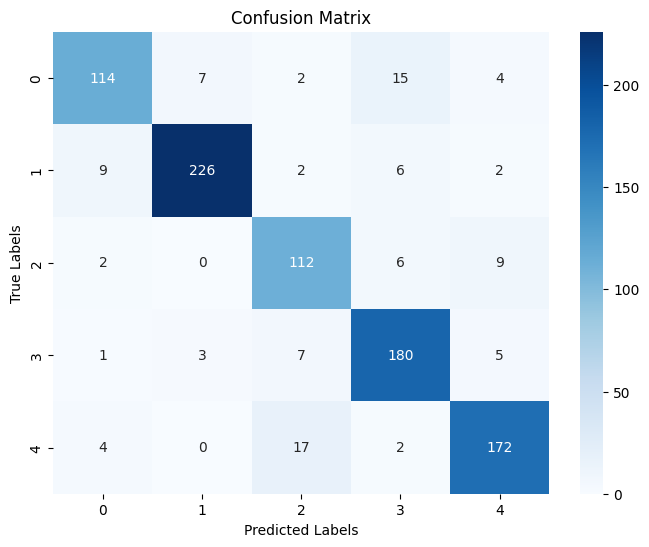

In [8]:
# 혼동행렬
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 모델 테스트 후 혼동 행렬 계산 함수
def plot_confusion_matrix(model, dataloader, device):
    model.eval()  # 모델을 평가 모드로 전환
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())  # CPU로 옮겨서 리스트에 추가
            all_labels.extend(labels.cpu().numpy())

    # 혼동 행렬 계산
    cm = confusion_matrix(all_labels, all_preds)

    # 혼동 행렬 시각화
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# 학습 후 혼동 행렬 출력
plot_confusion_matrix(model, test_loader, device)

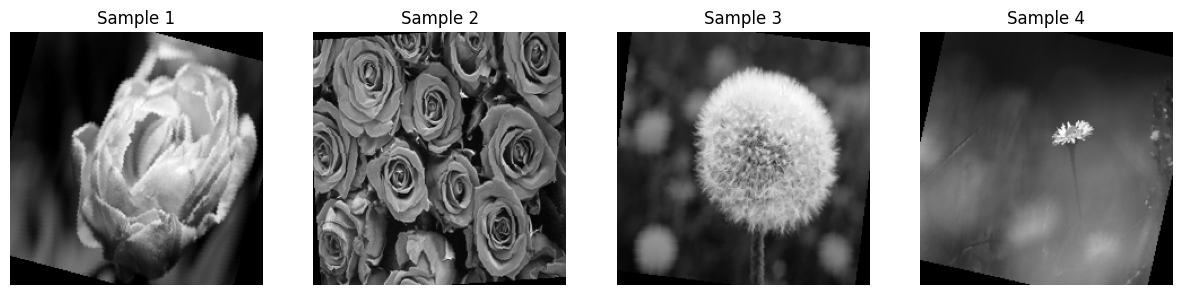

In [11]:
# grayscale 적용된 사진 보여주기

import matplotlib.pyplot as plt
import torch

# 데이터 로더에서 4개 배치 가져오기
data_iter = iter(train_loader)
images, labels = next(data_iter)

# 4개만 선택
images = images[:4]

# Grayscale 변환
grayscale_images = images.mean(dim=1)

# 시각화
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
for i in range(4):
    axes[i].imshow(grayscale_images[i].cpu().numpy(), cmap="gray")
    axes[i].axis("off")
    axes[i].set_title(f"Sample {i+1}")

plt.show()

# VGG(츨력층)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Train Loss: 0.6242, Train Accuracy: 77.55%
Validation Loss: 0.4305, Validation Accuracy: 84.36%
Epoch 2, Train Loss: 0.2822, Train Accuracy: 90.44%
Validation Loss: 0.3028, Validation Accuracy: 91.27%
Epoch 3, Train Loss: 0.2499, Train Accuracy: 91.35%
Validation Loss: 0.3815, Validation Accuracy: 88.55%
Epoch 4, Train Loss: 0.1667, Train Accuracy: 93.76%
Validation Loss: 0.2871, Validation Accuracy: 92.91%
Epoch 5, Train Loss: 0.1437, Train Accuracy: 95.13%
Validation Loss: 0.3345, Validation Accuracy: 89.09%
Epoch 6, Train Loss: 0.0837, Train Accuracy: 97.31%
Validation Loss: 0.2905, Validation Accuracy: 92.18%
Epoch 7, Train Loss: 0.1102, Train Accuracy: 96.36%
Validation Loss: 0.2713, Validation Accuracy: 92.18%
Epoch 8, Train Loss: 0.0850, Train Accuracy: 97.18%
Validation Loss: 0.4981, Validation Accuracy: 91.27%
Epoch 9, Train Loss: 0.0744, Train Accuracy: 97.95%
Validation Loss: 0.3828, Validation Accuracy: 90.55%
Epoch 10, Train Loss: 0.1038, Train Accuracy: 96.72%
Va

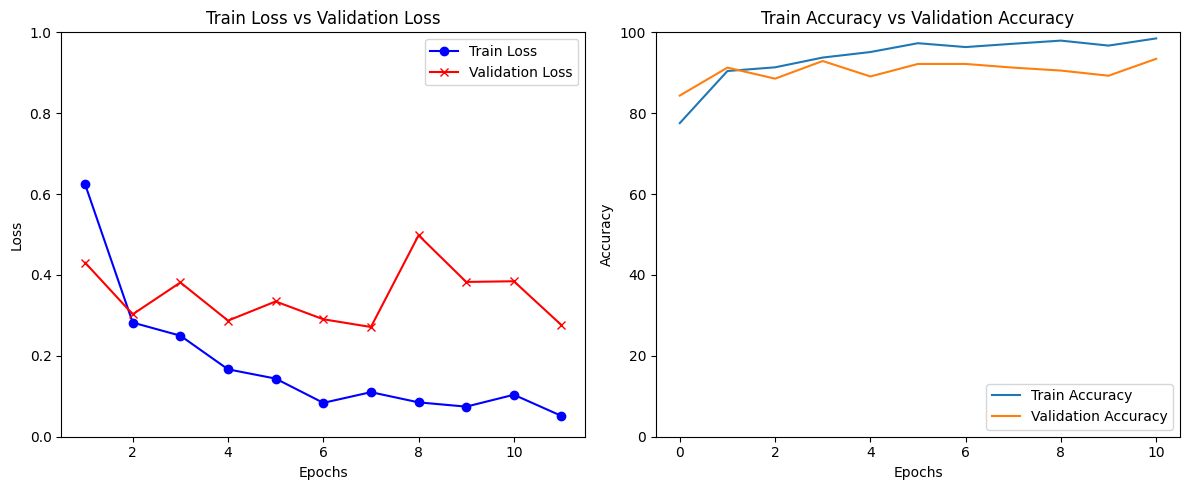

Train Losses:  [0.6241756321295447, 0.28223239776232967, 0.24987211585908697, 0.16666112060024255, 0.14373069776195116, 0.0837311102549775, 0.11019424424655196, 0.08496818970213982, 0.07437645394668874, 0.10380669189380833, 0.05142323436397735]
Validation Losses:  [0.43050459937916863, 0.3028114131755299, 0.3814576255778472, 0.28710892734428245, 0.3345126813898484, 0.29046000480755335, 0.27132699359208345, 0.49812543392181396, 0.38275693895088303, 0.3844609496494134, 0.2759833529643301]
Test Accuracy: 0.92%


In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch.optim.lr_scheduler as lr_scheduler
import glob


# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# 데이터셋 클래스 정의
class FlowerDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        img = Image.open(img_path)
        if self.transform:
            img = self.transform(img)
        return img, label


# 모델 정의
class VGG16Model(nn.Module):
    def __init__(self, num_classes=5, dropout_prob=0.3):
        super(VGG16Model, self).__init__()
        self.model = models.vgg16(pretrained=True)

        self.model.classifier[6] = nn.Sequential(
            nn.Dropout(p=dropout_prob),
            nn.Linear(self.model.classifier[6].in_features, 5)
        )

        # 모든 레이어의 파라미터를 학습 가능하도록 설정
        for param in self.model.parameters():
            param.requires_grad = True

    def forward(self, x):
        return self.model(x)


# 모델 학습 및 평가 클래스
class TrainModel:
    def __init__(self, model, train_loader, val_loader, test_loader, lr=0.0001, patience=4, scheduler_step_size=10, scheduler_gamma=0.5):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=0.0005) #L2 정규화 적용
        self.patience = patience
        self.best_val_loss = float('inf')
        self.early_stop_counter = 0
        self.scheduler = lr_scheduler.StepLR(self.optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma)

        self.train_losses = []
        self.train_accuracies = []
        self.val_losses = []
        self.val_accuracies = []

        self.test_accuracy = None

    def train(self, epochs):
        for epoch in range(epochs):
            self.model.train()
            running_loss = 0.0
            correct_train = 0
            total_train = 0
            for images, labels in self.train_loader:
                images, labels = images.to(device), labels.to(device)
                self.optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()

            train_loss = running_loss / len(self.train_loader)
            train_accuracy = 100 * correct_train / total_train
            self.train_losses.append(train_loss)
            self.train_accuracies.append(train_accuracy)
            print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

            val_loss = self.evaluate(self.val_loader)
            val_accuracy = 100 * self.evaluate_accuracy(self.val_loader)
            self.val_losses.append(val_loss)
            self.val_accuracies.append(val_accuracy)

            print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

            # Early Stopping 조건 체크
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.early_stop_counter = 0
            else:
                self.early_stop_counter += 1
                if self.early_stop_counter >= self.patience:
                    print("Early stopping triggered")
                    break

            self.scheduler.step()

        self.test_accuracy = self.evaluate_accuracy(self.test_loader)
        print(f"Test Accuracy: {self.test_accuracy * 100:.2f}%")

        self.plot_graph()

        return {
            'train_losses': self.train_losses,
            'train_accuracies': self.train_accuracies,
            'val_losses': self.val_losses,
            'val_accuracies': self.val_accuracies,
            'test_accuracy': self.test_accuracy
        }

    def evaluate(self, loader):
        self.model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in loader:
                images, labels = images.to(device), labels.to(device)
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(loader)
        return avg_val_loss

    def evaluate_accuracy(self, loader):
        self.model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in loader:
                images, labels = images.to(device), labels.to(device)
                outputs = self.model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = correct / total
        return accuracy

    def plot_graph(self):
        if len(self.train_losses) > 0 and len(self.val_accuracies) > 0:  # 리스트가 비어있는지 체크
            epochs = range(1, len(self.train_losses) + 1)  # train_losses의 길이에 맞추기

        plt.figure(figsize=(12, 5))

        ax1 = plt.subplot(1, 2, 1)
        ax1.plot(epochs, self.train_losses, 'b-o', label='Train Loss')
        ax1.plot(epochs, self.val_losses, 'r-x', label='Validation Loss')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax1.legend(loc='upper right')
        ax1.set_title('Train Loss vs Validation Loss')
        ax1.set_ylim(0, 1)  # y축 범위 설정

        ax2 = plt.subplot(1, 2, 2)  # 1행 2열의 두 번째 서브플롯
        ax2.plot(self.train_accuracies, label='Train Accuracy')
        ax2.plot(self.val_accuracies, label='Validation Accuracy')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Accuracy')
        ax2.legend(loc='lower right')
        ax2.set_title('Train Accuracy vs Validation Accuracy')
        ax2.set_ylim(0, 100)  # y축 범위 설정

        plt.tight_layout()  # 레이아웃 조정
        plt.show()


# Flower Dataset 폴더 경로와 class 이름 설정
train_data_path = "/content/drive/MyDrive/Colab Notebooks/Kakao/개인 project/flowers-dataset/train"
test_data_path = "/content/drive/MyDrive/Colab Notebooks/Kakao/개인 project/flowers-dataset/labeled_test"

# 이미지 경로와 레이블 준비
train_image_paths = glob.glob(os.path.join(train_data_path, '*', '*.jpg'))
test_image_paths = glob.glob(os.path.join(test_data_path, '*', '*.jpg'))

# 클래스 이름 딕셔너리 정의
labels_dict = {'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}

# 꽃 종류별 라벨링
train_labels = [labels_dict[os.path.basename(os.path.dirname(img_path))] for img_path in train_image_paths]
test_labels = [labels_dict[os.path.basename(os.path.dirname(img_path))] for img_path in test_image_paths]

# 데이터셋 분할 (train과 val 데이터셋 분할)
train_paths, val_paths, train_labels, val_labels = train_test_split(train_image_paths, train_labels, test_size=0.2, random_state=42)

# 이미지 전처리 및 데이터 로더 설정
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Dataset 클래스 정의 및 로더 설정
train_dataset = FlowerDataset(train_paths, train_labels, transform=train_transform)
val_dataset = FlowerDataset(val_paths, val_labels, transform=val_test_transform)
test_dataset = FlowerDataset(test_image_paths, test_labels, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 모델과 학습 클래스 준비
model = VGG16Model(num_classes=5)
trainer = TrainModel(model, train_loader, val_loader, test_loader)

# 학습 시작
results = trainer.train(epochs=20)

# 결과 확인
print("Train Losses: ", results['train_losses'])
print("Validation Losses: ", results['val_losses'])
print(f"Test Accuracy: {results['test_accuracy']:.2f}%")

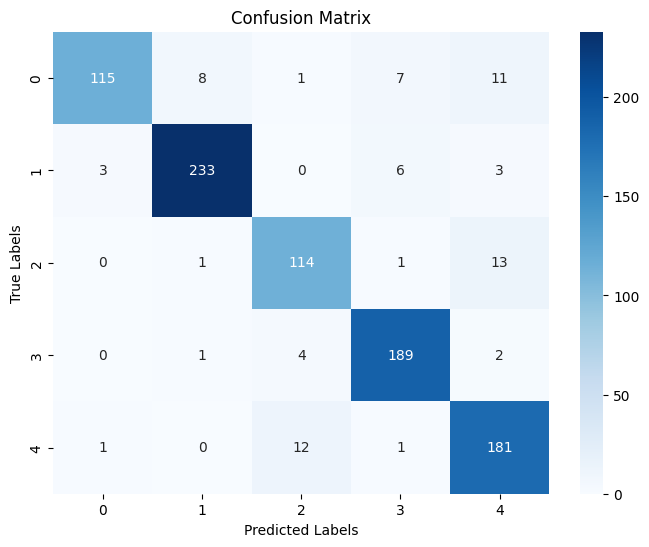

In [20]:
# 혼동행렬
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 모델 테스트 후 혼동 행렬 계산 함수
def plot_confusion_matrix(model, dataloader, device):
    model.eval()  # 모델을 평가 모드로 전환
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())  # CPU로 옮겨서 리스트에 추가
            all_labels.extend(labels.cpu().numpy())

    # 혼동 행렬 계산
    cm = confusion_matrix(all_labels, all_preds)

    # 혼동 행렬 시각화
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# 학습 후 혼동 행렬 출력
plot_confusion_matrix(model, test_loader, device)

# 새로운 출력층 만들기 - 비교를 위해 dropout 0.5로 설정

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Train Loss: 0.5125, Train Accuracy: 82.15%
Validation Loss: 0.2849, Validation Accuracy: 90.91%
Epoch 2, Train Loss: 0.1778, Train Accuracy: 94.17%
Validation Loss: 0.2299, Validation Accuracy: 93.45%
Epoch 3, Train Loss: 0.1393, Train Accuracy: 95.26%
Validation Loss: 0.3484, Validation Accuracy: 89.45%
Epoch 4, Train Loss: 0.1006, Train Accuracy: 97.09%
Validation Loss: 0.3245, Validation Accuracy: 90.55%
Epoch 5, Train Loss: 0.0925, Train Accuracy: 97.04%
Validation Loss: 0.2598, Validation Accuracy: 91.82%
Epoch 6, Train Loss: 0.0620, Train Accuracy: 98.36%
Validation Loss: 0.2417, Validation Accuracy: 92.00%
Early stopping triggered
Test Accuracy: 91.73%


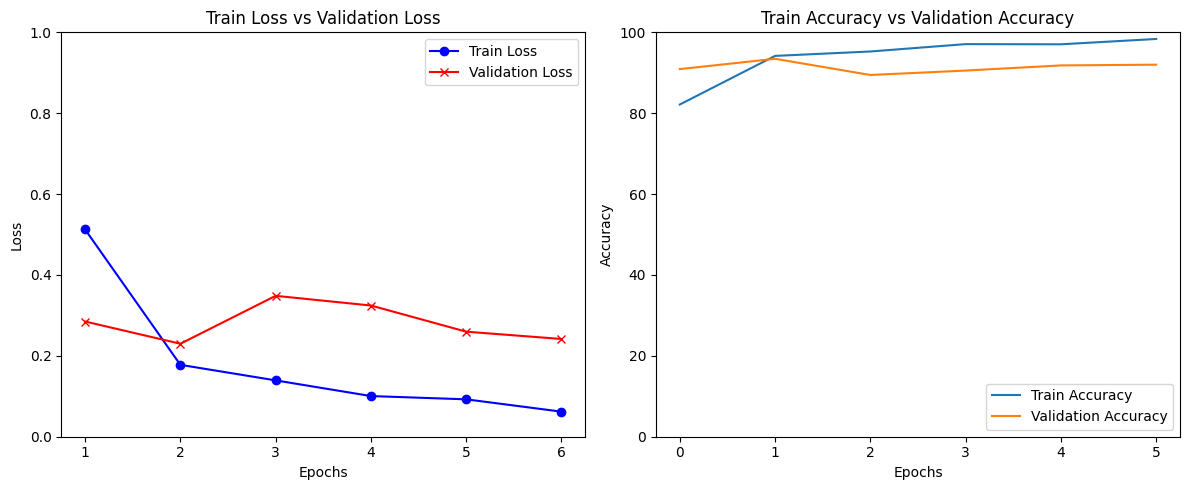

Train Losses:  [0.5125099753124126, 0.17777991003316382, 0.13934509242898313, 0.10055856632095748, 0.09245032505334719, 0.061981398976691394]
Validation Losses:  [0.2849162191980415, 0.22993005067110062, 0.34841091599729324, 0.3244536966085434, 0.2597647580421633, 0.2416984863424053]
Test Accuracy: 0.92%


In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch.optim.lr_scheduler as lr_scheduler
import glob


# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# 데이터셋 클래스 정의
class FlowerDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        img = Image.open(img_path)
        if self.transform:
            img = self.transform(img)
        return img, label


# 모델 정의 - 새로운 출력층 만들기
class ResNet50Model(nn.Module):
    def __init__(self, num_classes=5, dropout_prob=0.5):
        super(ResNet50Model, self).__init__()
        self.model = models.resnet50(pretrained=True)

        self.model.fc = nn.Sequential(
            nn.Dropout(p=dropout_prob),
            nn.Linear(self.model.fc.in_features, num_classes)
        )

        # 기본적으로 모든 파라미터를 학습 가능하게 설정
        for param in self.model.parameters():
            param.requires_grad = True

    def forward(self, x):
        return self.model(x)


# 모델 학습 및 평가 클래스
class TrainModel:
    def __init__(self, model, train_loader, val_loader, test_loader, lr=0.0001, patience=4, scheduler_step_size=10, scheduler_gamma=0.5):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=0.0005) #L2 정규화 적용
        self.patience = patience
        self.best_val_loss = float('inf')
        self.early_stop_counter = 0
        self.scheduler = lr_scheduler.StepLR(self.optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma)

        self.train_losses = []
        self.train_accuracies = []
        self.val_losses = []
        self.val_accuracies = []

        self.test_accuracy = None

    def train(self, epochs):
        for epoch in range(epochs):
            self.model.train()
            running_loss = 0.0
            correct_train = 0
            total_train = 0
            for images, labels in self.train_loader:
                images, labels = images.to(device), labels.to(device)
                self.optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()

            train_loss = running_loss / len(self.train_loader)
            train_accuracy = 100 * correct_train / total_train
            self.train_losses.append(train_loss)
            self.train_accuracies.append(train_accuracy)
            print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

            val_loss = self.evaluate(self.val_loader)
            val_accuracy = 100 * self.evaluate_accuracy(self.val_loader)
            self.val_losses.append(val_loss)
            self.val_accuracies.append(val_accuracy)

            print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

            # Early Stopping 조건 체크
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.early_stop_counter = 0
            else:
                self.early_stop_counter += 1
                if self.early_stop_counter >= self.patience:
                    print("Early stopping triggered")
                    break

            self.scheduler.step()

        self.test_accuracy = self.evaluate_accuracy(self.test_loader)
        print(f"Test Accuracy: {self.test_accuracy * 100:.2f}%")

        self.plot_graph()

        return {
            'train_losses': self.train_losses,
            'train_accuracies': self.train_accuracies,
            'val_losses': self.val_losses,
            'val_accuracies': self.val_accuracies,
            'test_accuracy': self.test_accuracy
        }

    def evaluate(self, loader):
        self.model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in loader:
                images, labels = images.to(device), labels.to(device)
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(loader)
        return avg_val_loss

    def evaluate_accuracy(self, loader):
        self.model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in loader:
                images, labels = images.to(device), labels.to(device)
                outputs = self.model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = correct / total
        return accuracy

    def plot_graph(self):
        if len(self.train_losses) > 0 and len(self.val_accuracies) > 0:  # 리스트가 비어있는지 체크
            epochs = range(1, len(self.train_losses) + 1)  # train_losses의 길이에 맞추기

        plt.figure(figsize=(12, 5))

        ax1 = plt.subplot(1, 2, 1)
        ax1.plot(epochs, self.train_losses, 'b-o', label='Train Loss')
        ax1.plot(epochs, self.val_losses, 'r-x', label='Validation Loss')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax1.legend(loc='upper right')
        ax1.set_title('Train Loss vs Validation Loss')
        ax1.set_ylim(0, 1)  # y축 범위 설정

        ax2 = plt.subplot(1, 2, 2)  # 1행 2열의 두 번째 서브플롯
        ax2.plot(self.train_accuracies, label='Train Accuracy')
        ax2.plot(self.val_accuracies, label='Validation Accuracy')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Accuracy')
        ax2.legend(loc='lower right')
        ax2.set_title('Train Accuracy vs Validation Accuracy')
        ax2.set_ylim(0, 100)  # y축 범위 설정

        plt.tight_layout()  # 레이아웃 조정
        plt.show()


# Flower Dataset 폴더 경로와 class 이름 설정
train_data_path = "/content/drive/MyDrive/Colab Notebooks/Kakao/개인 project/flowers-dataset/train"
test_data_path = "/content/drive/MyDrive/Colab Notebooks/Kakao/개인 project/flowers-dataset/labeled_test"

# 이미지 경로와 레이블 준비
train_image_paths = glob.glob(os.path.join(train_data_path, '*', '*.jpg'))
test_image_paths = glob.glob(os.path.join(test_data_path, '*', '*.jpg'))

# 클래스 이름 딕셔너리 정의
labels_dict = {'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}

# 꽃 종류별 라벨링
train_labels = [labels_dict[os.path.basename(os.path.dirname(img_path))] for img_path in train_image_paths]
test_labels = [labels_dict[os.path.basename(os.path.dirname(img_path))] for img_path in test_image_paths]

# 데이터셋 분할 (train과 val 데이터셋 분할)
train_paths, val_paths, train_labels, val_labels = train_test_split(train_image_paths, train_labels, test_size=0.2, random_state=42)

# 이미지 전처리 및 데이터 로더 설정
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Dataset 클래스 정의 및 로더 설정
train_dataset = FlowerDataset(train_paths, train_labels, transform=train_transform)
val_dataset = FlowerDataset(val_paths, val_labels, transform=val_test_transform)
test_dataset = FlowerDataset(test_image_paths, test_labels, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 모델과 학습 클래스 준비
model = ResNet50Model(num_classes=5)
trainer = TrainModel(model, train_loader, val_loader, test_loader)

# 학습 시작
results = trainer.train(epochs=20)

# 결과 확인
print("Train Losses: ", results['train_losses'])
print("Validation Losses: ", results['val_losses'])
print(f"Test Accuracy: {results['test_accuracy']:.2f}%")

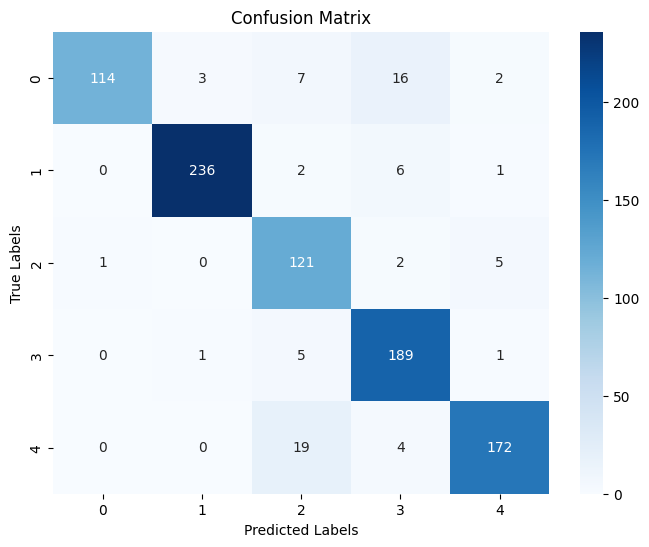

In [22]:
# 혼동행렬
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 모델 테스트 후 혼동 행렬 계산 함수
def plot_confusion_matrix(model, dataloader, device):
    model.eval()  # 모델을 평가 모드로 전환
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())  # CPU로 옮겨서 리스트에 추가
            all_labels.extend(labels.cpu().numpy())

    # 혼동 행렬 계산
    cm = confusion_matrix(all_labels, all_preds)

    # 혼동 행렬 시각화
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# 학습 후 혼동 행렬 출력
plot_confusion_matrix(model, test_loader, device)

# 출력층에 dropout하기 - dropout 0.5로 설정

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Train Loss: 1.7145, Train Accuracy: 71.72%
Validation Loss: 0.3692, Validation Accuracy: 90.36%
Epoch 2, Train Loss: 0.2419, Train Accuracy: 93.58%
Validation Loss: 0.3168, Validation Accuracy: 92.55%
Epoch 3, Train Loss: 0.1799, Train Accuracy: 94.54%
Validation Loss: 0.3494, Validation Accuracy: 91.64%
Epoch 4, Train Loss: 0.1385, Train Accuracy: 95.99%
Validation Loss: 0.3085, Validation Accuracy: 90.18%
Epoch 5, Train Loss: 0.0768, Train Accuracy: 97.22%
Validation Loss: 0.2888, Validation Accuracy: 91.82%
Epoch 6, Train Loss: 0.0497, Train Accuracy: 98.41%
Validation Loss: 0.3061, Validation Accuracy: 93.09%
Epoch 7, Train Loss: 0.0644, Train Accuracy: 98.13%
Validation Loss: 0.2888, Validation Accuracy: 92.36%
Epoch 8, Train Loss: 0.0699, Train Accuracy: 97.91%
Validation Loss: 0.2139, Validation Accuracy: 93.64%
Epoch 9, Train Loss: 0.0733, Train Accuracy: 97.68%
Validation Loss: 0.2248, Validation Accuracy: 94.18%
Epoch 10, Train Loss: 0.0715, Train Accuracy: 98.41%
Va

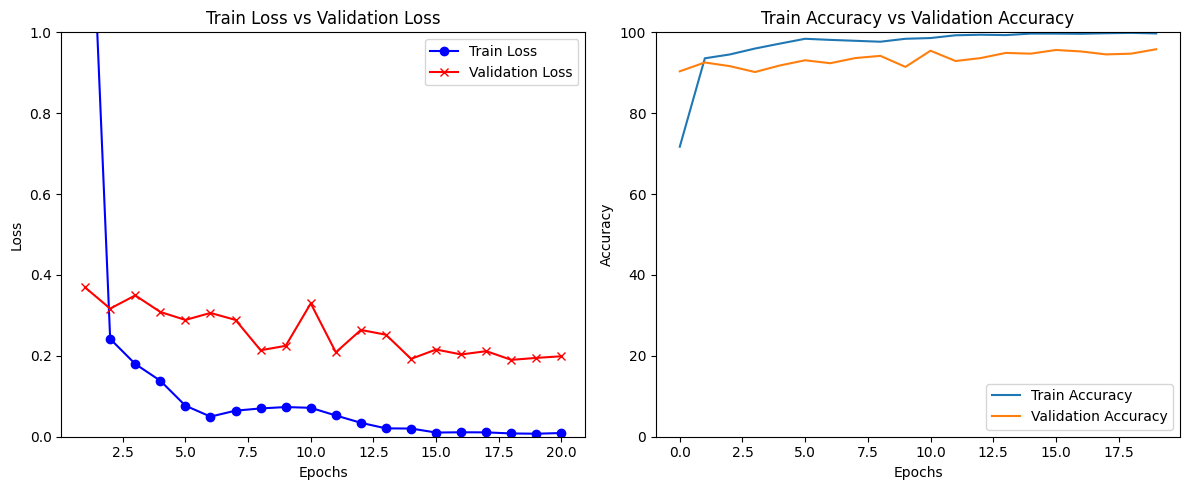

Train Losses:  [1.714476890700019, 0.24189775604484737, 0.17989250631544038, 0.13847938748211533, 0.07681386051969467, 0.04971840404028046, 0.0644348808935425, 0.06993510634165959, 0.07334862078668253, 0.07148208043308578, 0.052546564850659255, 0.03441501370010277, 0.020662657550428117, 0.02022915205072976, 0.010338161864901718, 0.010990364117247553, 0.010742574468115006, 0.00807179134162784, 0.0074585584802991725, 0.009117327659623697]
Validation Losses:  [0.3691792125917143, 0.31684502710898715, 0.349447941304081, 0.3085090670113762, 0.28878506314423347, 0.3061052806054552, 0.2888108698858155, 0.21387330763455895, 0.2247587906765855, 0.32966841177807915, 0.2088334560394287, 0.2640595163943039, 0.2521928599518206, 0.19256084583078822, 0.21564263814232415, 0.2034221339919087, 0.21158483650328386, 0.19007744557327694, 0.19493894072042572, 0.19897206438084444]
Test Accuracy: 0.94%


In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch.optim.lr_scheduler as lr_scheduler
import glob


# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# 데이터셋 클래스 정의
class FlowerDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        img = Image.open(img_path)
        if self.transform:
            img = self.transform(img)
        return img, label


# 모델 정의 - 출력층 자체에 dropout
class ResNet50Model(nn.Module):
    def __init__(self, num_classes=5, dropout_prob=0.5):
        super(ResNet50Model, self).__init__()
        self.model = models.resnet50(pretrained=True)

        self.model.fc = nn.Sequential(
        nn.Dropout(p=dropout_prob),  # Dropout 추가
        self.model.fc  # 기존 출력층 유지
        )

        # 기본적으로 모든 파라미터를 학습 가능하게 설정
        for param in self.model.parameters():
            param.requires_grad = True

    def forward(self, x):
        return self.model(x)

# 모델 학습 및 평가 클래스
class TrainModel:
    def __init__(self, model, train_loader, val_loader, test_loader, lr=0.0001, patience=5, scheduler_step_size=10, scheduler_gamma=0.5):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=0.0005) #L2 정규화 적용
        self.patience = patience
        self.best_val_loss = float('inf')
        self.early_stop_counter = 0
        self.scheduler = lr_scheduler.StepLR(self.optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma)

        self.train_losses = []
        self.train_accuracies = []
        self.val_losses = []
        self.val_accuracies = []

        self.test_accuracy = None

    def train(self, epochs):
        for epoch in range(epochs):
            self.model.train()
            running_loss = 0.0
            correct_train = 0
            total_train = 0
            for images, labels in self.train_loader:
                images, labels = images.to(device), labels.to(device)
                self.optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()

            train_loss = running_loss / len(self.train_loader)
            train_accuracy = 100 * correct_train / total_train
            self.train_losses.append(train_loss)
            self.train_accuracies.append(train_accuracy)
            print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

            val_loss = self.evaluate(self.val_loader)
            val_accuracy = 100 * self.evaluate_accuracy(self.val_loader)
            self.val_losses.append(val_loss)
            self.val_accuracies.append(val_accuracy)

            print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

            # Early Stopping 조건 체크
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.early_stop_counter = 0
            else:
                self.early_stop_counter += 1
                if self.early_stop_counter >= self.patience:
                    print("Early stopping triggered")
                    break

            self.scheduler.step()

        self.test_accuracy = self.evaluate_accuracy(self.test_loader)
        print(f"Test Accuracy: {self.test_accuracy * 100:.2f}%")

        self.plot_graph()

        return {
            'train_losses': self.train_losses,
            'train_accuracies': self.train_accuracies,
            'val_losses': self.val_losses,
            'val_accuracies': self.val_accuracies,
            'test_accuracy': self.test_accuracy
        }

    def evaluate(self, loader):
        self.model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in loader:
                images, labels = images.to(device), labels.to(device)
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(loader)
        return avg_val_loss

    def evaluate_accuracy(self, loader):
        self.model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in loader:
                images, labels = images.to(device), labels.to(device)
                outputs = self.model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = correct / total
        return accuracy

    def plot_graph(self):
        if len(self.train_losses) > 0 and len(self.val_accuracies) > 0:  # 리스트가 비어있는지 체크
            epochs = range(1, len(self.train_losses) + 1)  # train_losses의 길이에 맞추기

        plt.figure(figsize=(12, 5))

        ax1 = plt.subplot(1, 2, 1)
        ax1.plot(epochs, self.train_losses, 'b-o', label='Train Loss')
        ax1.plot(epochs, self.val_losses, 'r-x', label='Validation Loss')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax1.legend(loc='upper right')
        ax1.set_title('Train Loss vs Validation Loss')
        ax1.set_ylim(0, 1)  # y축 범위 설정

        ax2 = plt.subplot(1, 2, 2)  # 1행 2열의 두 번째 서브플롯
        ax2.plot(self.train_accuracies, label='Train Accuracy')
        ax2.plot(self.val_accuracies, label='Validation Accuracy')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Accuracy')
        ax2.legend(loc='lower right')
        ax2.set_title('Train Accuracy vs Validation Accuracy')
        ax2.set_ylim(0, 100)  # y축 범위 설정

        plt.tight_layout()  # 레이아웃 조정
        plt.show()


# Flower Dataset 폴더 경로와 class 이름 설정
train_data_path = "/content/drive/MyDrive/Colab Notebooks/Kakao/개인 project/flowers-dataset/train"
test_data_path = "/content/drive/MyDrive/Colab Notebooks/Kakao/개인 project/flowers-dataset/labeled_test"

# 이미지 경로와 레이블 준비
train_image_paths = glob.glob(os.path.join(train_data_path, '*', '*.jpg'))
test_image_paths = glob.glob(os.path.join(test_data_path, '*', '*.jpg'))

# 클래스 이름 딕셔너리 정의
labels_dict = {'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}

# 꽃 종류별 라벨링
train_labels = [labels_dict[os.path.basename(os.path.dirname(img_path))] for img_path in train_image_paths]
test_labels = [labels_dict[os.path.basename(os.path.dirname(img_path))] for img_path in test_image_paths]

# 데이터셋 분할 (train과 val 데이터셋 분할)
train_paths, val_paths, train_labels, val_labels = train_test_split(train_image_paths, train_labels, test_size=0.2, random_state=42)

# 이미지 전처리 및 데이터 로더 설정
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Dataset 클래스 정의 및 로더 설정
train_dataset = FlowerDataset(train_paths, train_labels, transform=train_transform)
val_dataset = FlowerDataset(val_paths, val_labels, transform=val_test_transform)
test_dataset = FlowerDataset(test_image_paths, test_labels, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 모델과 학습 클래스 준비
model = ResNet50Model(num_classes=5)
trainer = TrainModel(model, train_loader, val_loader, test_loader)

# 학습 시작
results = trainer.train(epochs=20)

# 결과 확인
print("Train Losses: ", results['train_losses'])
print("Validation Losses: ", results['val_losses'])
print(f"Test Accuracy: {results['test_accuracy']:.2f}%")

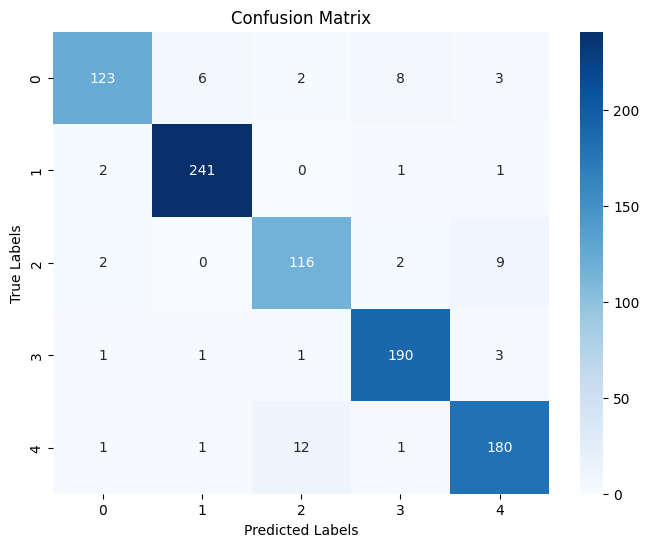

In [24]:
# 혼동행렬
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 모델 테스트 후 혼동 행렬 계산 함수
def plot_confusion_matrix(model, dataloader, device):
    model.eval()  # 모델을 평가 모드로 전환
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())  # CPU로 옮겨서 리스트에 추가
            all_labels.extend(labels.cpu().numpy())

    # 혼동 행렬 계산
    cm = confusion_matrix(all_labels, all_preds)

    # 혼동 행렬 시각화
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# 학습 후 혼동 행렬 출력
plot_confusion_matrix(model, test_loader, device)

# 은닉층 - dropout 0.5

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Train Loss: 0.4995, Train Accuracy: 83.38%
Validation Loss: 0.2747, Validation Accuracy: 91.82%
Epoch 2, Train Loss: 0.2010, Train Accuracy: 93.31%
Validation Loss: 0.2244, Validation Accuracy: 93.09%
Epoch 3, Train Loss: 0.1166, Train Accuracy: 95.86%
Validation Loss: 0.1539, Validation Accuracy: 93.82%
Epoch 4, Train Loss: 0.1012, Train Accuracy: 96.86%
Validation Loss: 0.2061, Validation Accuracy: 93.82%
Epoch 5, Train Loss: 0.0709, Train Accuracy: 97.95%
Validation Loss: 0.2052, Validation Accuracy: 93.09%
Epoch 6, Train Loss: 0.0605, Train Accuracy: 97.95%
Validation Loss: 0.1817, Validation Accuracy: 92.91%
Epoch 7, Train Loss: 0.0513, Train Accuracy: 98.36%
Validation Loss: 0.1549, Validation Accuracy: 94.73%
Epoch 8, Train Loss: 0.0819, Train Accuracy: 97.59%
Validation Loss: 0.2599, Validation Accuracy: 92.00%
Early stopping triggered
Test Accuracy: 91.07%


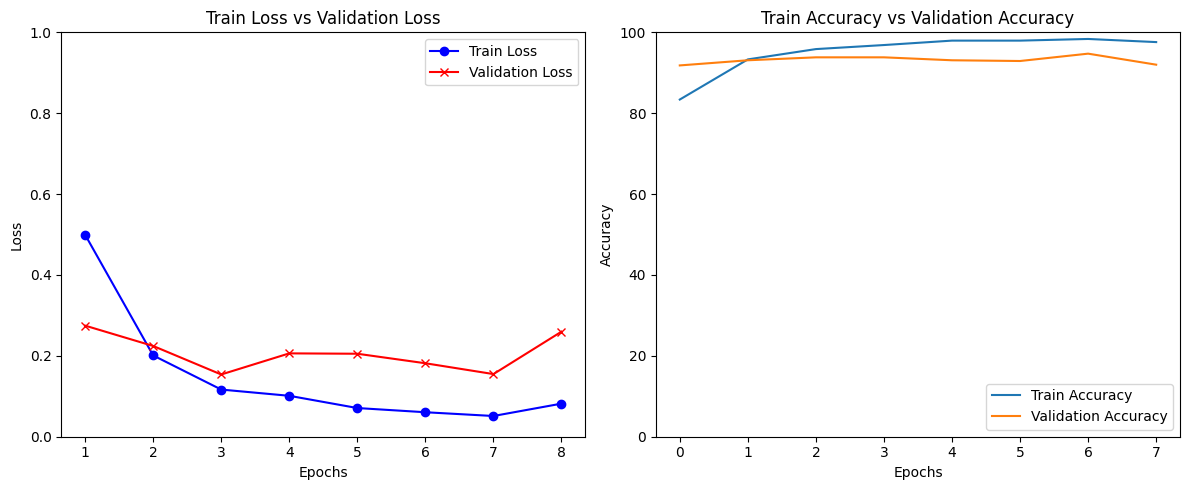

Train Losses:  [0.49951176496519556, 0.2010175103618615, 0.11663728153360063, 0.10119466887166102, 0.07094143833830088, 0.0605435674281224, 0.05125380630699405, 0.08185128576756603]
Validation Losses:  [0.2747165448963642, 0.22441681971152624, 0.15390188909239239, 0.2061227392922673, 0.2051970368872086, 0.1816698104246623, 0.15490508436535796, 0.25986138907157713]
Test Accuracy: 0.91%


In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch.optim.lr_scheduler as lr_scheduler
import glob


# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# 데이터셋 클래스 정의
class FlowerDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        img = Image.open(img_path)
        if self.transform:
            img = self.transform(img)
        return img, label


# 모델 정의
class ResNet50Model(nn.Module):
    def __init__(self, num_classes=5, dropout_prob=0.5):
        super(ResNet50Model, self).__init__()
        self.model = models.resnet50(pretrained=True)

        # avgpool과 fc 사이에 Dropout 추가
        self.model.avgpool = nn.Sequential(
            self.model.avgpool,
            nn.Dropout(p=dropout_prob)
        )

        # Fully Connected Layer 수정
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

        # 기본적으로 모든 파라미터를 학습 가능하게 설정
        for param in self.model.parameters():
            param.requires_grad = True

    def forward(self, x):
        return self.model(x)

# 모델 학습 및 평가 클래스
class TrainModel:
    def __init__(self, model, train_loader, val_loader, test_loader, lr=0.0001, patience=5, scheduler_step_size=10, scheduler_gamma=0.5):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=0.0005) #L2 정규화 적용
        self.patience = patience
        self.best_val_loss = float('inf')
        self.early_stop_counter = 0
        self.scheduler = lr_scheduler.StepLR(self.optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma)

        self.train_losses = []
        self.train_accuracies = []
        self.val_losses = []
        self.val_accuracies = []

        self.test_accuracy = None

    def train(self, epochs):
        for epoch in range(epochs):
            self.model.train()
            running_loss = 0.0
            correct_train = 0
            total_train = 0
            for images, labels in self.train_loader:
                images, labels = images.to(device), labels.to(device)
                self.optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()

            train_loss = running_loss / len(self.train_loader)
            train_accuracy = 100 * correct_train / total_train
            self.train_losses.append(train_loss)
            self.train_accuracies.append(train_accuracy)
            print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

            val_loss = self.evaluate(self.val_loader)
            val_accuracy = 100 * self.evaluate_accuracy(self.val_loader)
            self.val_losses.append(val_loss)
            self.val_accuracies.append(val_accuracy)

            print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

            # Early Stopping 조건 체크
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.early_stop_counter = 0
            else:
                self.early_stop_counter += 1
                if self.early_stop_counter >= self.patience:
                    print("Early stopping triggered")
                    break

            self.scheduler.step()

        self.test_accuracy = self.evaluate_accuracy(self.test_loader)
        print(f"Test Accuracy: {self.test_accuracy * 100:.2f}%")

        self.plot_graph()

        return {
            'train_losses': self.train_losses,
            'train_accuracies': self.train_accuracies,
            'val_losses': self.val_losses,
            'val_accuracies': self.val_accuracies,
            'test_accuracy': self.test_accuracy
        }

    def evaluate(self, loader):
        self.model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in loader:
                images, labels = images.to(device), labels.to(device)
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(loader)
        return avg_val_loss

    def evaluate_accuracy(self, loader):
        self.model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in loader:
                images, labels = images.to(device), labels.to(device)
                outputs = self.model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = correct / total
        return accuracy

    def plot_graph(self):
        if len(self.train_losses) > 0 and len(self.val_accuracies) > 0:  # 리스트가 비어있는지 체크
            epochs = range(1, len(self.train_losses) + 1)  # train_losses의 길이에 맞추기

        plt.figure(figsize=(12, 5))

        ax1 = plt.subplot(1, 2, 1)
        ax1.plot(epochs, self.train_losses, 'b-o', label='Train Loss')
        ax1.plot(epochs, self.val_losses, 'r-x', label='Validation Loss')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax1.legend(loc='upper right')
        ax1.set_title('Train Loss vs Validation Loss')
        ax1.set_ylim(0, 1)  # y축 범위 설정

        ax2 = plt.subplot(1, 2, 2)  # 1행 2열의 두 번째 서브플롯
        ax2.plot(self.train_accuracies, label='Train Accuracy')
        ax2.plot(self.val_accuracies, label='Validation Accuracy')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Accuracy')
        ax2.legend(loc='lower right')
        ax2.set_title('Train Accuracy vs Validation Accuracy')
        ax2.set_ylim(0, 100)  # y축 범위 설정

        plt.tight_layout()  # 레이아웃 조정
        plt.show()


# Flower Dataset 폴더 경로와 class 이름 설정
train_data_path = "/content/drive/MyDrive/Colab Notebooks/Kakao/개인 project/flowers-dataset/train"
test_data_path = "/content/drive/MyDrive/Colab Notebooks/Kakao/개인 project/flowers-dataset/labeled_test"

# 이미지 경로와 레이블 준비
train_image_paths = glob.glob(os.path.join(train_data_path, '*', '*.jpg'))
test_image_paths = glob.glob(os.path.join(test_data_path, '*', '*.jpg'))

# 클래스 이름 딕셔너리 정의
labels_dict = {'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}

# 꽃 종류별 라벨링
train_labels = [labels_dict[os.path.basename(os.path.dirname(img_path))] for img_path in train_image_paths]
test_labels = [labels_dict[os.path.basename(os.path.dirname(img_path))] for img_path in test_image_paths]

# 데이터셋 분할 (train과 val 데이터셋 분할)
train_paths, val_paths, train_labels, val_labels = train_test_split(train_image_paths, train_labels, test_size=0.2, random_state=42)

# 이미지 전처리 및 데이터 로더 설정
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Dataset 클래스 정의 및 로더 설정
train_dataset = FlowerDataset(train_paths, train_labels, transform=train_transform)
val_dataset = FlowerDataset(val_paths, val_labels, transform=val_test_transform)
test_dataset = FlowerDataset(test_image_paths, test_labels, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 모델과 학습 클래스 준비
model = ResNet50Model(num_classes=5)
trainer = TrainModel(model, train_loader, val_loader, test_loader)

# 학습 시작
results = trainer.train(epochs=20)

# 결과 확인
print("Train Losses: ", results['train_losses'])
print("Validation Losses: ", results['val_losses'])
print(f"Test Accuracy: {results['test_accuracy']:.2f}%")

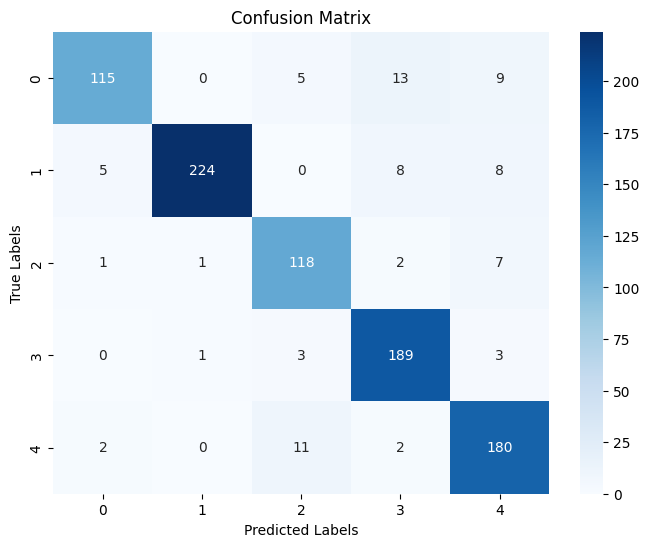

In [26]:
# 혼동행렬
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 모델 테스트 후 혼동 행렬 계산 함수
def plot_confusion_matrix(model, dataloader, device):
    model.eval()  # 모델을 평가 모드로 전환
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())  # CPU로 옮겨서 리스트에 추가
            all_labels.extend(labels.cpu().numpy())

    # 혼동 행렬 계산
    cm = confusion_matrix(all_labels, all_preds)

    # 혼동 행렬 시각화
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# 학습 후 혼동 행렬 출력
plot_confusion_matrix(model, test_loader, device)